<center><font size="6">Хакатон от Моторики</font>

[Первый этап](https://www.kaggle.com/competitions/motorica-gesture-classification-task/data)

Команда 1

# Условие задачи, загрузка и описание данных 

Задача: мультиклассовая классификация “распознавания жестов”.  
Построить классификационную модель, которая по показаниям от датчиков будет определять жест, выполненный пользователем протеза во время записи данных, что отражено в значении целевой переменной.

* X_train.npy - обучающая выборка имеющая размерности "наблюдения, датчики, время"
* X_test.npy - тестоваая выборка имеющая размерности "наблюдения, датчики, время"
* y_train.npy - целевая переменная для обучающей выборки, которая содержит следующие классы:

| Номер <br> класса | Описание |
| :---: | :--- |
| "0"  |  разгиб жеста "grab" |
| "1"  |  разгиб жеста "ok" |
| "2"  |  разгиб большого пальца |
| "3"  |  разгиб указательного пальца |
| "4"  |  разгиб жеста "пистолет" |
| "5"  |  разгиб среднего пальца |
| "6"  |  разгиб безымянного пальца |
| "7"  |  разгиб мизинца |
| "8"  |  сгиб мизинца |
| "9"  |  сгиб безымянного пальца |
| "10" |  сгиб среднего пальца |
| "11" |  сгиб жеста "пистолет" |
| "12" |  сгиб указательного пальца |
| "13" |  сгиб большого пальца |
| "14" |  сгиб жеста "ok" |
| "15" |  сгиб жеста "grab" |

# Погружение в задачу

Для улучшения функционала бионических кистевых протезов была предложена задача «распознавания жестов» на основании данных оптомиографических датчиков.
    
Оптомиография (ОМГ) - молодой метод мониторинга мышечной активности, был предложен всего лишь в 2015 году. За время исследований ОМГ показала превосходное соотношение сигнал/шум и повышенную устойчивость к внешним мешающим факторам по сравнению с данными электромиографии и механомиографии.  Основной принцип ОМГ заключается в использовании активных оптических датчиков ближнего инфракрасного диапазона для измерения вариаций измеряемых сигналов, которые отражаются от поверхности кожи, при одновременной активации мышц ниже и вокруг участка кожи, на который фокусируется фотоэлектрический датчик. Каждый сигнал OMГ считывается в определенном месте на поверхности кожи путем фокусировки непрерывного маломощного ближнего инфракрасного (NIR) луча на этом участке кожи и измерения отраженных сигналов в течение определенного периода времени. Интенсивность обнаруженного сигнала зависит как от расстояния, так и от наклона поверхности кожи по отношению к направлению датчика и испускаемого NIR-луча, а также от характеристик подкожных мягких тканей (жировая клетчатка и мышечные структуры).

Принцип работы заключается в том, что световой поток от источника NIR фокусируется на поверхности кожи. При этом свет частично отражается обратно и детектируется фототранзистором, а также частично рассеивается в мягких тканях (Рис. 2).

<center> <img src = "figures/fig_1.png" width=300, height=250>

**Рис.1 - Детектирование расслабления мышцы \
с помощью оптомиографического датчика** </center>

Когда мышца сокращается, степень рассеивания пучка уменьшается, тем самым плотность отраженного света увеличивается (рис. 3), что приводит к увеличению тока и напряжения в детекторе. 

<center> <img src = "figures/fig_2.png" width=300, height=250>

**Рис.2 - Детектирование напряжения мышцы \
с помощью оптомиографического датчика** 

                      

Когда рука находится в состоянии покоя, изменений отражающей способности кожи не регистрируется, поэтому на выходе фототранзистора регистрируется постоянное значение напряжения. При возникновении движения происходит изменение параметров среды для прохождения светового пучка, следовательно изменяется количество света, попадающего на детектор. Важно понимать, что чем сильнее было изменение среды (а наиболее вероятно это связано именно с мышечным сокращением), тем больше будет разница первоначальных и конечных показаний датчиков. 

На основании этих данных перейдем непосредственно к анализу данных и решению задачи. 

# Import библиотек и описание функций

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np

# графические библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# библиотеки машинного обучения
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# отображать по умолчанию длину дата Датафрейма
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# библиотека взаимодействия с интерпретатором

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import os

### Подготовка данных

In [2]:
# проверяем все ли правильно
PATH = './'
print(os.listdir(PATH))

['.git', 'figures', 'functions.py', 'N1_sprint_2022.09.10_edited_2.ipynb', 'README.md', 'sample_submission.csv', 'submission_3.csv', 'X_test.npy', 'X_train.npy', 'y_train.csv', '__pycache__']


In [3]:
#загрузка обучающей выборки и меток классов
X_train = np.load(os.path.join(PATH, 'X_train.npy'))
y_train = pd.read_csv(os.path.join(PATH, 'y_train.csv'), sep='[-,]' , index_col='Id',  engine='python').reset_index(drop = True)


#загрузка тестовой выборки
X_test = np.load(os.path.join(PATH, 'X_test.npy'))

print(f"Размерность файла 'X_train': {X_train.shape}. Размерность: наблюдения, датчики, время")
print(f"Размерность файла 'y_train': {y_train.shape}. Размерность: наблюдения, время")

Размерность файла 'X_train': (165, 40, 60). Размерность: наблюдения, датчики, время
Размерность файла 'y_train': (165, 1). Размерность: наблюдения, время


In [4]:
# библиотека вызова функций
import functions as f

In [5]:
# #загрузка обучающей выборки и меток классов
# X_train = np.load('X_train.npy')
# y_train = pd.read_csv('y_train.csv', index_col='Id').reset_index(drop = True)

# #загрузка тестовой выборки
# X_test = np.load('X_test.npy')

# print(f"Размерность файла 'X_train': {X_train.shape}. Размерность: наблюдения, датчики, время")
# print(f"Размерность файла 'y_train': {y_train.shape}")

In [6]:
y_train.head()

,Class
0,5
1,8
2,11
3,9
4,14


Проанализируем распределение классов.

In [7]:
plot_counter = 3
fig = px.bar(
    data_frame=y_train.groupby(by='Class').value_counts(), 
    opacity=0.5, # непрозрачность
)

# Настройка отображения
fig.update_layout(
    title=dict(text=f'Рис. {plot_counter}'+'- Структура классов целевой переменной', x=.5, y=.01, xanchor='center'),
    xaxis_title_text = 'Номер класса',
    yaxis_title_text = 'Количество наблюдений<br> в классе',
    showlegend=False,
    width=600, height=400,
    margin=dict(l=100, r=60, t=80, b=70),
)
#fig.show()

fig.write_image(f'figures/fig_{plot_counter}.png', engine="kaleido")

<center> <img src = "figures/fig_3.png" width=600, height=400>

На рис.3 изображено распределение наблюдений по классам. Отметим, что классы сбалансированны, но количество наблюдений в классе небольшое.

In [8]:
# посмотрим на пример описания объекта: данные показателей сорока датчиков по 60ти временным отметкам

i = 0 #индекс объекта

pd.DataFrame(
    data = X_train[i], 
    index = [f'sensor_{s}' for s in range(X_train.shape[1])], 
    columns = [f'time_{s}' for s in range(X_train.shape[2])]
    )

,time_0,time_1,time_2,time_3,...,time_56,time_57,time_58,time_59
sensor_0,1331.0,1333.0,1331.0,1332.0,...,833.0,838.0,842.0,848.0
sensor_1,17.0,11.0,14.0,9.0,...,8.0,4.0,4.0,10.0
sensor_2,2580.0,2583.0,2581.0,2585.0,...,772.0,767.0,760.0,762.0
sensor_3,22.0,19.0,22.0,26.0,...,15.0,12.0,13.0,16.0
...,...,...,...,...,...,...,...,...,...
sensor_36,1730.0,1730.0,1731.0,1730.0,...,1924.0,1924.0,1928.0,1928.0
sensor_37,22.0,23.0,25.0,26.0,...,17.0,22.0,30.0,22.0
sensor_38,305.0,311.0,304.0,304.0,...,345.0,342.0,339.0,337.0
sensor_39,24.0,21.0,24.0,23.0,...,21.0,22.0,20.0,26.0


# Aнализ жестов и показателей датчиков

## Aнализ "разгиб жеста grab"

Выполним анализ класса 0 (жест "grab"), чтобы ближе познакомиться с данными.

In [9]:
gesture_0 = y_train[y_train['Class'] == 0].index
print(f"Индексы наблюдения жеста 0: {', '.join(gesture_0.astype(str))}")
print(f"Количетсво жестов 0 в обучающей выборке: {len(gesture_0)}")

Индексы наблюдения жеста 0: 9, 10, 22, 36, 61, 96, 109, 114, 142, 148, 159
Количетсво жестов 0 в обучающей выборке: 11


В качестве примера рассмотрим наблюдение 9 жеста 0. Отобразим показания датчиков на диаграмме

In [10]:
f.get_all_sensors_plot(9, X_train, plot_counter=4)

<center> <img src = "figures/fig_4.png" width=600, height=400></center>

Отметим, что датчики можно условно разделить на 2 группы по их амплитуде их показний на: 
- активные  (0, 2, 5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 36, 38). Их величина превышает 200;
- спящие (все остальные), величина менее 200.

Посмотрим на них раздельно.

In [11]:
active_sensors, passive_sensors, reliable_sensors, unreliable_sensors = f.get_sensor_list(9, X_train, print_active=True)

Активные датчики наблюдения 9:  [0, 2, 5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 36, 38]
Пассивные датчики наблюдения 9: [1, 3, 4, 6, 7, 9, 10, 11, 13, 14, 16, 18, 20, 22, 23, 25, 26, 28, 31, 32, 34, 35, 37, 39]


In [12]:
f.get_active_passive_sensors_plot(9, X_train, plot_counter=5)

<center> <img src = "figures/fig_5.png" ></center>

На Рис.5 слева представлены показания активных датчиков наблюдения 0-9, а справа - пассивных датчиков. Рассматривая динамику показаний активных датчиков во времени условно отметим 3 периода:
*  0 - 35 с. - "покой" и слабого изменения;
* 35 - 45 с. - "сильное колебание" показаний при движении;
* 45 - 60 с. - "стабилизаця" после движения.
Показания пассивных датчиков колеблются с низкой амплитудой 

В результате анализа наблюдения 0-9 "разгиб жеста "grab" установлено, что датчики можно условно разделить: 
- по амплитуде сигнала на 2 группы: активные и пассивные,
- по изменению во времени на 3 группы: "покой", "сильное колебание" и "стабилизация".

Проверим активность датчиков у жеста-антагониста №15 "сгиб жеста "grab".

## Анализ антагониста "сгиб жеста "grab"

In [13]:
gesture_15 = y_train[y_train['Class'] == 15].index
print(f"Индексы наблюдения жеста 15: {', '.join(gesture_15.astype(str))}")
print(f"Количетсво жестов 15 в обучающей выборке: {len(gesture_15)}")

Индексы наблюдения жеста 15: 21, 26, 29, 40, 54, 76, 81, 90, 116, 157, 163
Количетсво жестов 15 в обучающей выборке: 11


Исследуем произвольно выбранное наблюдение 21.

In [14]:
active_sensors, passive_sensors, reliable_sensors, unreliable_sensors = f.get_sensor_list(21, X_train, print_active=True)

Активные датчики наблюдения 21:  [0, 2, 5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 36, 38]
Пассивные датчики наблюдения 21: [1, 3, 4, 6, 7, 9, 10, 11, 13, 14, 16, 18, 20, 22, 23, 25, 26, 28, 31, 32, 34, 35, 37, 39]


Построим диаграмму сигналов

In [15]:
f.get_all_sensors_plot(21, X_train, plot_counter=6)

<center> <img src = "figures/fig_6.png" ></center>

## Анализ активности датчиков

### a) при выполнении различных жестов

Выясним какие датчики активны при исполнении жестов-антагонистов.  
Сравним показания активных датчиков с одинаковыми индексами в ходе выполнения  жестов:
* 0  - разгиб жеста "grab"
* 15 - сгиб жеста "grab"

In [16]:
gesture_0 = y_train[y_train['Class'] == 0].index
gesture_15 = y_train[y_train['Class'] == 15].index
print(gesture_0)
print(gesture_15)

Int64Index([9, 10, 22, 36, 61, 96, 109, 114, 142, 148, 159], dtype='int64')
Int64Index([21, 26, 29, 40, 54, 76, 81, 90, 116, 157, 163], dtype='int64')


In [17]:
# пустые списки для активных и пассивных датчиков
active_sensors_0, passive_sensors_0, reliable_sensors, unreliable_sensors = f.get_sensor_list(9, X_train, print_active=True)
active_sensors_15, passive_sensors_15, reliable_sensors, unreliable_sensors = f.get_sensor_list(21, X_train, print_active=True)

active_sensors_0 = pd.DataFrame({'Жест_0':active_sensors_0})
active_sensors_15 = pd.DataFrame({'Жест_15':active_sensors_15})
active_sensors_0_15 = active_sensors_0.join(active_sensors_15)

if list(active_sensors_0['Жест_0']) == list(active_sensors_15['Жест_15']):
  print("Да, массивы одинаковые") 
  display(active_sensors_0_15.head())
else: 
  print("no")

Активные датчики наблюдения 9:  [0, 2, 5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 36, 38]
Пассивные датчики наблюдения 9: [1, 3, 4, 6, 7, 9, 10, 11, 13, 14, 16, 18, 20, 22, 23, 25, 26, 28, 31, 32, 34, 35, 37, 39]
Активные датчики наблюдения 21:  [0, 2, 5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 36, 38]
Пассивные датчики наблюдения 21: [1, 3, 4, 6, 7, 9, 10, 11, 13, 14, 16, 18, 20, 22, 23, 25, 26, 28, 31, 32, 34, 35, 37, 39]
Да, массивы одинаковые


,Жест_0,Жест_15
0,0,0
1,2,2
2,5,5
3,8,8
4,12,12


В результате анализа установлено, что при жестах-антагонистах 15 и 0 наблюдается активность одинаковых датчиков во всех наблюдениях: 0, 2, 5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 36, 38. Остальные датчики неактивны. 

### b) при выполнении одного жеста

Выберем произвольно 4 датчика: 0, 2, 5, 33, а затем рассмотрим на диаграммах их активность во всех наблюдениях жеста 0:

In [18]:
y_train[y_train['Class']==15]

,Class
21,15
26,15
29,15
40,15
...,...
90,15
116,15
157,15
163,15


In [19]:
f.get_sensors_in_all_tests_plot(0, [0, 2, 5, 33], X_train, y_train, plot_counter=7)

На диаграммах рис.7 можно увидеть, что показания датчиков изменяются во времени с разной амплитудой. Амплитуда сигналов датчиков 0, 2, 5 ,больше, чем у датчика 33. Однако, изменения показаний у датчиков в разных наблюдениях одного жеста в среднем имеют одинаковый периодический характер: 
*  0 - 35 с. - "покой" и слабого изменения;
* 35 - 45 с. - "сильное колебание" показаний при движении;
* 45 - 60 с. - "стабилизаця" после движения.

Можно провести подобный анализ для других жестов и датчиков и сделать вывод, что распределение на активные и пассивные датчики сохраняется в остальных жестах.

# Построение модели

## Предлагаемое решение

На основании проведённого анализа предполагаем, что классы можно успешно разлелить по перепаду показателей датчиков до и после исполнения жестов.

Выберем логистическую регрессию в качестве предиктора. Это позволит нам как успешно решить задачу, так и выиграть в скорости обучения и предсказания по сравнению с более затратными ансамблевыми методами. 

Учитывая состояние "покоя" и периоды активности и фиксации показателей датчиков, в качестве признаков возьмём разность средних значений в первые 30 временных единиц и во вторые 30 временных единиц по каждому датчику для каждого объекта. Такое преобразование изменит размерность обучающей выборки из (165, 40, 60) в (165, 40), что сэкономит время на обучение и сохранит информативность.

Учитывая возможность того, что часть датчиков будет неинформативной или будет обладать избыточной информацией для модели, воспользуемся L1 регуляризацией для зануления коэфициентов модели для таких датчиков.

При необходимости воспользуемся подбором гиперпараметров.

## Преобразование данных

Преобразуем данные в соответствии с предложенным решением.  
В качестве признаков возьмём разность средних значений в первые 30 временных единиц и во вторые 30 временных единиц по каждому датчику для каждого объекта.

In [20]:
X_train_preproc = f.data_preproc(X_train)
X_train_preproc

,sensor_0,sensor_1,sensor_2,sensor_3,...,sensor_36,sensor_37,sensor_38,sensor_39
0,-315.966667,0.533333,-1074.6,-4.933333,...,129.466667,-1.633333,39.233333,0.733333
1,99.166667,0.7,181.366667,10.566667,...,-43.366667,1.433333,5.766667,2.366667
2,247.2,0.1,354.3,4.233333,...,-169.566667,0.9,-15.2,2.066667
3,-173.266667,0.066667,302.666667,1.233333,...,-152.533333,1.333333,41.833333,1.833333
...,...,...,...,...,...,...,...,...,...
161,23.533333,-0.433333,855.666667,4.033333,...,-120.133333,-1.566667,-40.666667,0.3
162,1.4,-0.366667,82.5,-1.633333,...,125.066667,2.333333,-99.333333,-0.7
163,295.3,1.466667,470.2,12.766667,...,-162.666667,1.366667,177.166667,2.333333
164,-31.0,1.5,-115.033333,1.366667,...,44.933333,0.333333,-144.233333,-0.266667


In [21]:
X_test_preproc = f.data_preproc(X_test)
X_test_preproc

,sensor_0,sensor_1,sensor_2,sensor_3,...,sensor_36,sensor_37,sensor_38,sensor_39
0,96.833333,0.366667,634.533333,0.033333,...,-162.166667,0.2,-30.4,0.166667
1,0.233333,1.533333,86.066667,-9.666667,...,96.466667,0.2,-225.933333,-1.533333
2,160.6,-0.633333,1059.666667,2.366667,...,-194.2,-1.666667,-40.2,0.7
3,51.966667,0.566667,83.366667,0.0,...,41.333333,0.1,240.8,0.433333
...,...,...,...,...,...,...,...,...,...
162,19.2,-0.066667,101.766667,-0.933333,...,6.933333,-1.833333,121.9,0.133333
163,238.3,-4.3,345.333333,2.433333,...,58.433333,-1.0,-174.333333,1.4
164,-179.533333,0.566667,194.633333,-0.933333,...,-96.766667,0.333333,39.666667,1.0
165,163.9,-0.233333,-293.033333,-1.866667,...,173.533333,-4.066667,-51.4,-2.4


## Тестирование и выбор модели

### Log

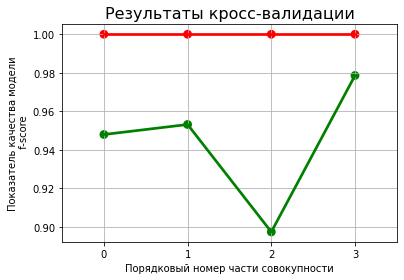

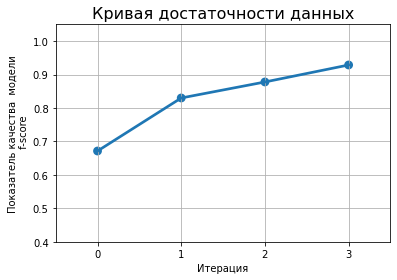

,cv_train,cv_test,cv_dif
0,1.0,0.944234,0.055766


In [22]:
cl = LogisticRegression()
f.stratified_cross_valid(cl, X_train_preproc, y_train, 4, 'f1_macro')
#plot.set_title('Рис.12 - Качество предсказания модели')
#plot.set_title('Рис.13 - Кривая достаточости данных')

### LogL1 (отбрасываем часть датчиков)

Применим L1 регуляризацию для отбрасывания части неинформативных (или избыточных) датчиков.

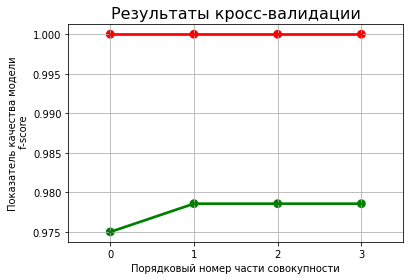

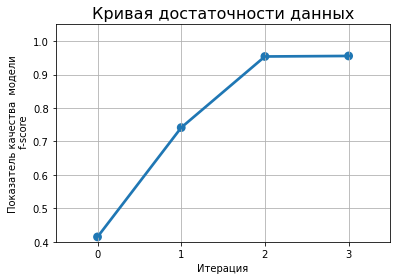

,cv_train,cv_test,cv_dif
0,1.0,0.977679,0.022321


In [23]:
cl = LogisticRegression(solver = 'liblinear', penalty = 'l1')
f.stratified_cross_valid(cl, X_train_preproc, y_train, 4, 'f1_macro')
#plot.set_title('Рис.14 - Качество предсказания модели')
#plot.set_title('Рис.15 - Кривая достаточости данных')

Модель в достаточной степени справляется с поставленной задачей и при увеличении количества объектов повышает свою эффективность.
На данном этапе подбирать гиперпараметры и подстраиваться под малое количество объектов не оправданно, поэтому мы принимаем данную модель без перебора коэффициента регуляризации.

In [24]:
cl = LogisticRegression(solver = 'liblinear', penalty = 'l1')
cl.fit(X_train_preproc, y_train)
#imp = pd.DataFrame(data = cl.coef_[0], index = X_train_preproc.columns)
#display(imp)

imp = pd.DataFrame({
    'sensor':X_train_preproc.columns,
    'value' :cl.coef_[0]})
display(imp)

,sensor,value
0,sensor_0,0.017488
1,sensor_1,0.000000
2,sensor_2,0.000187
3,sensor_3,0.000000
...,...,...
36,sensor_36,-0.015844
37,sensor_37,0.000000
38,sensor_38,0.009041
39,sensor_39,0.000000


In [25]:
sensors_id = list()
sensors_df=pd.DataFrame()
for i in imp['sensor']:
    sensors_id.append(int(i.replace('sensor_',"")))
sensors_id = pd.DataFrame({'sensors_id':sensors_id})
#display(sensors_id)
sensors_df = pd.concat([sensors_id, imp], axis=1)
#display(sensors_df)
sensors_df.drop(['sensor'], axis=1, inplace=True)
display(sensors_df)

print(f"Модель считает данные датчики полезными (достаточными) для предсказаний: {sensors_df.query('value !=0')['sensors_id']}")
print(f"Модель считает данные датчики избыточными для предсказаний датчики: {sensors_df.query('value == 0')['sensors_id']}")

,sensors_id,value
0,0,0.017488
1,1,0.000000
2,2,0.000187
3,3,0.000000
...,...,...
36,36,-0.015844
37,37,0.000000
38,38,0.009041
39,39,0.000000


Модель считает данные датчики полезными (достаточными) для предсказаний: 0      0
2      2
5      5
8      8
      ..
29    29
30    30
36    36
38    38
Name: sensors_id, Length: 15, dtype: int64
Модель считает данные датчики избыточными для предсказаний датчики: 1      1
3      3
4      4
6      6
      ..
34    34
35    35
37    37
39    39
Name: sensors_id, Length: 25, dtype: int64


# Submition

In [26]:
cl = LogisticRegression(solver = 'liblinear', penalty = 'l1')
cl.fit(X_train_preproc, y_train)
sub_predict = cl.predict(X_test_preproc)

In [27]:
sub_predict

array([10,  1, 10, 13,  4,  5, 15,  7,  3, 13,  2,  3,  5,  8, 12,  7,  0,
       11, 12,  4, 12, 14,  4, 10,  0, 10, 15,  5,  6,  4, 15,  1,  2, 15,
       12, 12,  9,  8, 14,  2, 12,  3,  8, 14,  3,  8, 13, 13,  7, 10,  4,
        1,  1, 13, 11, 13, 12,  0,  6,  2,  1,  6, 11,  3,  6,  3,  5, 11,
       13,  5, 14,  2,  7, 15, 15,  4,  2,  6,  0,  7,  8,  5,  9, 11,  1,
        5, 15,  8,  8, 14, 14,  1,  2, 11,  9,  1,  5, 14,  3,  9,  5,  2,
       10, 15,  9,  7, 10, 10,  4,  9,  6, 14,  6, 12,  0, 11,  2,  8,  3,
       11, 13,  7, 10, 10, 11,  5,  6,  0,  9, 10, 12,  8,  0,  8,  7,  3,
       12,  4,  9, 15,  2,  4,  4,  7,  6,  6,  1,  9,  3, 11, 13,  8, 12,
        0,  7,  2,  1,  0, 15,  0,  9, 13, 13,  3,  9,  6], dtype=int64)

In [28]:
submission = pd.read_csv('sample_submission.csv')
submission['Class'] = sub_predict

In [ ]:
# submission.to_csv('submission_3.csv', index = False)

Скор = 1.0 на LB